# 3D MESH

In [1]:
import sys, os, glob
sys.path.append('../')

import numpy as np
from ipywidgets import interact, fixed

from MRIsegm.utils import get_slice, get_slice_info, get_rois, explore_slice, mask_slice, display_images
from MRIsegm.processing import denoise_slice
from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss, soft_dice_loss
from tensorflow.keras.models import load_model

### Loading data

In [2]:
src = '/Users/giuseppefilitto/Pazienti_anonym_sorted/'
patient = 'BO11/'
dir_path =  src + patient + 'T2AX'

slice_raw = get_slice(dir_path=dir_path)
alpha = 5
slice = denoise_slice(slice_raw, alpha = alpha)

get_slice_info(slice=slice)

roi_path = src + patient + 'T2ROI'

rois = get_rois(roi_path=roi_path) 
positions = [rois[i].get('position') - 1 for i in range(len(rois))]

# set(positions) to have unique values
print(f"number of masks = {len(set(positions))}")

The image object has the following dimensions: depth:30, height:512, width:512
number of masks = 17


### Loading models

In [3]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

models_dir = '../data/models'
models_path = glob.glob(models_dir + '/*.h5')

dependencies = {
    'DiceBCEloss': DiceBCEloss,
    'dice_coef': dice_coef,
    'soft_dice_loss':soft_dice_loss
    
}

keys = [ os.path.splitext(os.path.split(models_path[i])[1])[0] for i, mod in enumerate(models_path)]
values = [ load_model(models_path[i], custom_objects=dependencies) for i, mod in enumerate(models_path)]

models = dict(zip(keys, values))

### Resizing and predicting

In [4]:
import cv2


def resize_slice(slice, IMAGE_HEIGHT, IMAGE_WIDTH):
    
    resized_slice = np.zeros(shape=(slice.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

    for layer in range(slice.shape[0]):
        
        norm = slice[layer, : ,:]*1./255
        resized =  cv2.resize(norm,IMG_SIZE, interpolation = cv2.INTER_CUBIC)
        resized = resized[np.newaxis, : ,:, np.newaxis]
        resized_slice[layer, :, :, :] = resized

    return resized_slice

def predict_slice(slice, model, threshold):
    
    predicted_slice = np.zeros(shape=(slice.shape), dtype=np.float32)

    for layer in range(slice.shape[0]):
        
        resized =  cv2.resize(slice[layer, : ,:],IMG_SIZE, interpolation = cv2.INTER_CUBIC)
        resized = resized[np.newaxis, : ,:, np.newaxis]
        predicted_slice[layer, :, :, :] = model.predict(resized) > threshold
    
    return predicted_slice

### Test on chosen model

In [5]:
print(models.keys())

dict_keys(['UNET-L4-F64_128_128_opt=adam_loss=binary_crossentropy', 'UNET-L4-F64_128_128_opt=adam_loss=soft_dice_loss', 'UNET-L4-F64_128_128_opt=adam_loss=DiceBCEloss'])


In [6]:
test_model = values[0]

resized_slice = resize_slice(slice, IMAGE_HEIGHT, IMAGE_WIDTH)
predicted_images = predict_slice(slice=resized_slice, model=test_model, threshold=0.6)

In [7]:
slice_of_masks = mask_slice(slice=slice, rois=rois)

### Showing predicted layer 

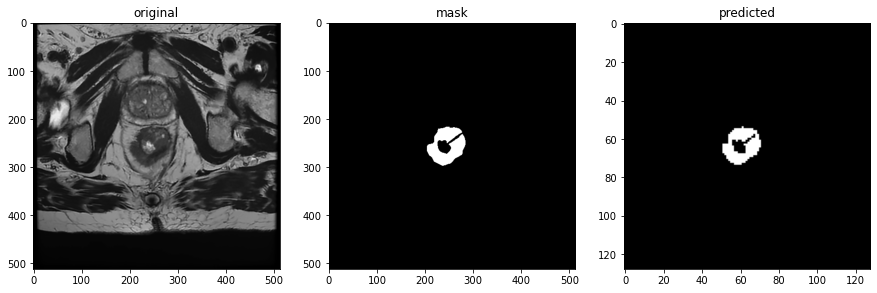

In [8]:
layer = 15
original = slice[layer, : ,:]
mask = slice_of_masks[layer, : ,:]
predicted = predicted_images[layer, : ,:]

display_images([original, mask, predicted ],figsize=(15,7), titles=['original', 'mask', 'predicted'] )
#explore_slice(slice=predicted_images, layer=layer)

In [9]:
interact(explore_slice, slice=fixed(predicted_images), layer=(0, slice.shape[0]-1) )

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

<function MRIsegm.utils.explore_slice(slice, layer)>

### Mesh-plot

In [10]:
from skimage.measure import marching_cubes
squeezed = np.squeeze(predicted_images, axis=-1)
vertices_, faces_,_,_ = marching_cubes(squeezed)

In [11]:
import meshplot as mp 
mp.plot(vertices_, faces_)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(14.5, 65.…